In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:1


NOTAS:
- Se consiguen resultado prácticamente iguales con y sin bias
- Clara diferencia usando optimización alterna vs única pasada (la única iba mejor con LR=0.05 y WD=0.01)

In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Dataset must be from DGL
dataset_name = 'WisconsinDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: WisconsinDataset
Number of nodes: 251
Number of features: 1703
Shape of signals: torch.Size([251, 1703])
Number of classes: 5
Norm of A: 22.69361114501953
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.13
Edge homophily: 0.20


# Without normalizing the GSO

In [4]:
# BEST PARAMETERS  -  0.874
## Training params
N_RUNS = 10
N_EPOCHS = 200  # 100
EPOCHS_h = 25
EPOCHS_W = 25
LR = .005
WD = .001
DROPOUT = .25

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 3  # 2
HID_DIM = 32  # 32

## Model params
h0 = 1  # 1
NORM = False

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.LeakyReLU() 
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [5]:
# Parameters
epochs = N_EPOCHS
epochs_h = EPOCHS_h
epochs_W = EPOCHS_W
lr =  .005 #LR
wd = .005  #WD
drop = DROPOUT
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
h0_aux = 1
norm = False
act = ACT
lact = LAST_ACT
loss_fn = LOSS_FN
patience = 200
bias = True

iters_aux = 1

err1 = np.zeros(iters_aux)
err2 = np.zeros(iters_aux)
for i in range(iters_aux):

    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)

    # Create model
    arch = GFGCN(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
                dropout=drop, init_h0=h0_aux, bias=bias)
    S = torch.Tensor(A).to(device)
    model = GF_NodeClassModel(arch, S, K, masks, loss_fn, device=device)
    loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W,
                            patience=patience)

    idx_max_acc = np.argmax(acc["val"])
    print(f'Best val acc: {acc["val"][idx_max_acc]:.3f}  -  Best test acc: {np.max(acc["test"]):.3f}')
    print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}')

    acc_val = model.test(feat, S, labels, masks['val'])
    acc_test = model.test(feat, S, labels, masks['test'])
    print(f'Val acc: {acc_val:.3f}  -  Test acc: {acc_test:.3f}')

    err1[i] = acc["test"][idx_max_acc]
    err2[i] = acc_test



Best val acc: 0.850  -  Best test acc: 0.843
Test acc at best val: 0.804
Val acc: 0.838  -  Test acc: 0.804


Acc at best val acc: 0.804 +- 0.000
Acc at test: 0.804 +- 0.000


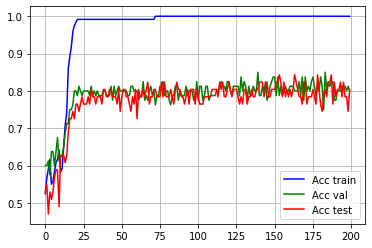

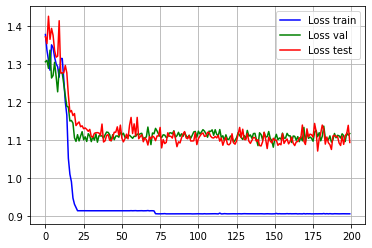

In [6]:
print(f'Acc at best val acc: {err1.mean():.3f} +- {err1.std():.3f}')
print(f'Acc at test: {err2.mean():.3f} +- {err1.std():.3f}')

# Plot
plt.figure(figsize=[6,4])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[6,4])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [7]:
EXPS = [
        {'epochs': 200, 'lr': .005, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .25},

        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-2, 'drop': .25},

        # {'epochs': 500, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        # {'epochs': 500, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .001, 'wd': 5e-3, 'drop': .25},


        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': 0},

        
        # {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .5},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        # {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .5},

        # {'epochs': 750, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 750, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 750, 'lr': .001, 'wd': 1e-3, 'drop': .25},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'],
                             epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)



-1: 200-0.005-0.0001-0.25: 0.863 (0.882)
-1: 200-0.005-0.0005-0.25: 0.863 (0.882)
-1: 200-0.01-0.001-0.25: 0.843 (0.902)
-1: 200-0.005-0.001-0.25: 0.824 (0.882)
-1: 200-0.005-0.001-0.5: 0.804 (0.882)
-1: 200-0.001-0.001-0.25: 0.745 (0.765)
-1: 200-0.05-0.005-0.25: 0.804 (0.882)
-1: 200-0.01-0.005-0.25: 0.863 (0.863)
-1: 200-0.005-0.005-0.25: 0.824 (0.863)
-1: 200-0.001-0.005-0.25: 0.784 (0.804)
-1: 200-0.05-0.01-0.25: 0.843 (0.882)
-1: 200-0.005-0.01-0.25: 0.804 (0.824)
-1: 200-0.05-0.01-0.5: 0.784 (0.882)
-1: 200-0.05-0.005-0.5: 0.804 (0.882)
-1: 200-0.01-0.005-0.5: 0.882 (0.882)
-1: 200-0.05-0.01-0: 0.804 (0.843)
-1: 200-0.05-0.005-0: 0.804 (0.863)
-1: 200-0.01-0.005-0: 0.784 (0.784)
-1: 500-0.005-0.001-0.5: 0.824 (0.882)
-2: 200-0.005-0.0001-0.25: 0.902 (0.922)
-2: 200-0.005-0.0005-0.25: 0.824 (0.922)
-2: 200-0.01-0.001-0.25: 0.725 (0.941)
-2: 200-0.005-0.001-0.25: 0.784 (0.922)
-2: 200-0.005-0.001-0.5: 0.843 (0.922)
-2: 200-0.001-0.001-0.25: 0.824 (0.882)
-2: 200-0.05-0.005-0.25: 0

In [8]:
table1


,mean accs,med,std
200-0.005-0.0001-0.25,0.868627,0.862745,0.029149
200-0.005-0.0005-0.25,0.866667,0.872549,0.027451
200-0.01-0.001-0.25,0.843137,0.843137,0.047222
200-0.005-0.001-0.25,0.872549,0.882353,0.046607
200-0.005-0.001-0.5,0.854902,0.862745,0.048189
200-0.001-0.001-0.25,0.766667,0.764706,0.046772
200-0.05-0.005-0.25,0.843137,0.833333,0.035076
200-0.01-0.005-0.25,0.864706,0.852941,0.034467
200-0.005-0.005-0.25,0.852941,0.862745,0.028074
200-0.001-0.005-0.25,0.837255,0.843137,0.034018


## Model params

In [9]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        # {'h0': .001, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        
        # {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 5, 'alt': True},

        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 10, 'alt': True},
        
        {'h0': .1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 50, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
    ]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=exp['h0'])
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        if not exp['alt']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

-1: 0.01-1-1-True: 0.529 (0.549)
-1: 0.1-1-1-True: 0.471 (0.529)
-1: 1-1-1-True: 0.510 (0.588)
-1: 1-1-1-False: 0.529 (0.529)
-1: 1-1-1-False: 0.451 (0.510)
-1: 1-5-1-True: 0.706 (0.745)
-1: 1-10-1-True: 0.706 (0.784)
-1: 1-10-5-True: 0.843 (0.882)
-1: 1-1-5-True: 0.490 (0.588)
-1: 1-1-10-True: 0.471 (0.569)
-1: 1-5-10-True: 0.725 (0.784)
-1: 0.1-10-10-True: 0.843 (0.863)
-1: 1-10-10-True: 0.843 (0.882)
-1: 1-25-25-True: 0.804 (0.824)
-1: 1-25-25-True: 0.824 (0.843)
-1: 0.1-25-25-True: 0.882 (0.902)
-1: 1-25-25-True: 0.863 (0.882)
-1: 1-50-50-True: 0.784 (0.882)
-2: 0.01-1-1-True: 0.608 (0.667)
-2: 0.1-1-1-True: 0.490 (0.627)
-2: 1-1-1-True: 0.451 (0.510)
-2: 1-1-1-False: 0.608 (0.647)
-2: 1-1-1-False: 0.863 (0.882)
-2: 1-5-1-True: 0.804 (0.863)
-2: 1-10-1-True: 0.843 (0.863)
-2: 1-10-5-True: 0.863 (0.863)
-2: 1-1-5-True: 0.627 (0.706)
-2: 1-1-10-True: 0.667 (0.706)
-2: 1-5-10-True: 0.863 (0.902)
-2: 0.1-10-10-True: 0.882 (0.922)
-2: 1-10-10-True: 0.882 (0.902)
-2: 1-25-25-True: 0.843 

In [10]:
table2

,mean accs,med,std
200-0.01-1-1-True,0.450980,0.431373,0.074407
200-0.1-1-1-True,0.486275,0.480392,0.040942
200-1-1-1-True,0.494118,0.509804,0.062500
200-1-1-1-False,0.529412,0.519608,0.035076
1000-1-1-1-False,0.537255,0.470588,0.143339
200-1-5-1-True,0.709804,0.705882,0.085828
200-1-10-1-True,0.752941,0.784314,0.082353
200-1-10-5-True,0.827451,0.833333,0.055321
200-1-1-5-True,0.511765,0.490196,0.053662
200-1-1-10-True,0.519608,0.509804,0.074536


## Architecture design - Bias True

In [12]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 50},
        {'L': 2, 'K': 2, 'hid_dim': 75},
        {'L': 2, 'K': 2, 'hid_dim': 100},

        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-16: 0.784 (0.882)
-1: 2-3-8: 0.765 (0.824)
-1: 2-3-16: 0.765 (0.882)
-1: 2-3-32: 0.843 (0.882)
-1: 2-4-16: 0.824 (0.863)
-1: 3-2-16: 0.843 (0.882)
-1: 4-2-16: 0.804 (0.882)
-1: 3-3-16: 0.824 (0.843)
-1: 4-3-16: 0.824 (0.863)
-1: 2-2-8: 0.784 (0.843)
-1: 2-2-32: 0.863 (0.882)
-1: 2-2-50: 0.824 (0.882)
-1: 2-2-75: 0.843 (0.882)
-1: 2-2-100: 0.843 (0.882)
-1: 2-3-50: 0.824 (0.882)
-1: 2-3-75: 0.843 (0.863)
-1: 2-3-100: 0.784 (0.843)
-1: 3-2-32: 0.843 (0.882)
-1: 3-2-50: 0.843 (0.882)
-1: 3-3-50: 0.824 (0.902)
-2: 2-2-16: 0.804 (0.902)
-2: 2-3-8: 0.863 (0.922)
-2: 2-3-16: 0.863 (0.902)
-2: 2-3-32: 0.882 (0.922)
-2: 2-4-16: 0.824 (0.902)
-2: 3-2-16: 0.863 (0.922)
-2: 4-2-16: 0.882 (0.902)
-2: 3-3-16: 0.863 (0.922)
-2: 4-3-16: 0.863 (0.922)
-2: 2-2-8: 0.882 (0.902)
-2: 2-2-32: 0.804 (0.922)
-2: 2-2-50: 0.882 (0.922)
-2: 2-2-75: 0.843 (0.922)
-2: 2-2-100: 0.824 (0.922)
-2: 2-3-50: 0.824 (0.941)
-2: 2-3-75: 0.863 (0.922)
-2: 2-3-100: 0.824 (0.941)
-2: 3-2-32: 0.882 (0.922)
-2: 3-2-50: 

In [13]:
table3

,mean accs,med,std
2-2-16,0.841176,0.833333,0.044237
2-3-8,0.817647,0.833333,0.060784
2-3-16,0.843137,0.852941,0.042959
2-3-32,0.874510,0.872549,0.026597
2-4-16,0.837255,0.823529,0.027799
3-2-16,0.856863,0.862745,0.019706
4-2-16,0.833333,0.843137,0.039460
3-3-16,0.841176,0.852941,0.040612
4-3-16,0.780392,0.823529,0.118559
2-2-8,0.774510,0.764706,0.080964


## GSO, bias, and batch norm

In [5]:
EXPS = [{'GSO': 'orig', 'bias': True, 'bn': False},
        {'GSO': 'trans', 'bias': True, 'bn': False},
        {'GSO': 'sym', 'bias': True, 'bn': False},

        {'GSO': 'orig', 'bias': True, 'bn': True},
        {'GSO': 'trans', 'bias': True, 'bn': True},
        {'GSO': 'sym', 'bias': True, 'bn': True},

        {'GSO': 'orig', 'bias': False, 'bn': False},
        {'GSO': 'sym', 'bias': False, 'bn': False},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, bias=False, batch_norm=exp['bn'])
        
        if exp['GSO'] == 'sym':
            A_aux = (A + A.T)/2
            A_aux = np.where(A_aux > 0, 1, 0)
        elif exp['GSO'] == 'trans':
            A_aux = A.T
        else:
            A_aux = A

        if NORM:
            S = torch.Tensor(normalize_gso(A_aux, 'both')).to(device)
        else:
            S = torch.Tensor(A_aux).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'- {i+1}: {exp["GSO"]}-{exp["bias"]}-{exp["bn"]}: {best_val_accs3b[j,i]:.3f} ({best_accs3b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["GSO"]}-{exp["bias"]}-{exp["bn"]}' for exp in EXPS]
table_over3b = summary_table(best_accs3b, index_name)
table3b = summary_table(best_val_accs3b, index_name)

- 1: orig-True-False: 0.824 (0.863)
- 1: trans-True-False: 0.843 (0.882)
- 1: sym-True-False: 0.529 (0.529)
- 1: orig-True-True: 0.765 (0.863)
- 1: trans-True-True: 0.882 (0.882)
- 1: sym-True-True: 0.804 (0.863)
- 1: orig-False-False: 0.843 (0.882)
- 1: sym-False-False: 0.824 (0.843)
- 2: orig-True-False: 0.922 (0.922)
- 2: trans-True-False: 0.804 (0.882)
- 2: sym-True-False: 0.627 (0.627)
- 2: orig-True-True: 0.765 (0.882)
- 2: trans-True-True: 0.765 (0.784)
- 2: sym-True-True: 0.765 (0.882)
- 2: orig-False-False: 0.863 (0.922)
- 2: sym-False-False: 0.627 (0.627)
- 3: orig-True-False: 0.882 (0.922)
- 3: trans-True-False: 0.863 (0.922)
- 3: sym-True-False: 0.941 (0.941)
- 3: orig-True-True: 0.706 (0.863)
- 3: trans-True-True: 0.745 (0.843)
- 3: sym-True-True: 0.843 (0.902)
- 3: orig-False-False: 0.902 (0.922)
- 3: sym-False-False: 0.412 (0.412)
- 4: orig-True-False: 0.882 (0.961)
- 4: trans-True-False: 0.882 (0.941)
- 4: sym-True-False: 0.431 (0.431)
- 4: orig-True-True: 0.922 (0.961)

In [8]:
table3b

,mean accs,med,std
orig-True-False,0.882353,0.882353,0.027730
trans-True-False,0.837255,0.833333,0.024880
sym-True-False,0.566667,0.490196,0.179162
orig-True-True,0.807843,0.803922,0.063112
trans-True-True,0.805882,0.803922,0.049176
sym-True-True,0.817647,0.833333,0.043888
orig-False-False,0.866667,0.872549,0.032575
sym-False-False,0.558824,0.490196,0.158630


## Nonlinearities and loss function

In [18]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        # {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.863)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.882 (0.882)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.412 (0.549)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.431 (0.471)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.784 (0.843)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.804 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.863 (0.882)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.804 (0.882)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.725 (0.824)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.824 (0.843)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.588 (0.588)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.922)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.902 (0.922)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.608 (0.667)
-2: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.529 (0.588)
-2: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.902 (0.922)
-2: ELU(alp

In [19]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.852941,0.843137,0.044063
ReLU()-Softmax(dim=1)-NLLLoss(),0.868627,0.872549,0.019706
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.454902,0.421569,0.102187
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.472549,0.460784,0.045943
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.856863,0.852941,0.037255
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.856863,0.872549,0.038273
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.882353,0.882353,0.019608
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.850980,0.852941,0.029346
Identity()-Softmax(dim=1)-CrossEntropyLoss(),0.835294,0.843137,0.051281
Identity()-Softmax(dim=1)-NLLLoss(),0.837255,0.833333,0.040232


# Normalizing the GSO

In [4]:
# BEST PARAMETERS  -  0.874
## Training params
N_RUNS = 10
NORM = True
N_EPOCHS = 200  # 750? --> repeat training params section
EPOCHS_h = 10 # 10
EPOCHS_W = 10 # 5
LR = .005
WD = .001
DROPOUT = .25

# BEST PARAMETERS
## Architecture params
N_LAYERS = 3
K = 2
HID_DIM = 50  # 32

## Model params
h0 = 1  # 1

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ReLU() 
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()

## Training paramerters

In [5]:
EXPS = [
        {'epochs': 200, 'lr': .005, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .25},

        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        
        {'epochs': 200, 'lr': .005, 'wd': 1e-2, 'drop': .25},

        {'epochs': 500, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 5e-3, 'drop': .25},


        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': 0},

        
        {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .5},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .5},

        {'epochs': 750, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 750, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 750, 'lr': .001, 'wd': 1e-3, 'drop': .25},
        ]

best_accs5 = np.zeros((len(EXPS), N_RUNS))
best_val_accs5 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'], epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs5[j,i] = np.max(acc["test"])
        best_val_accs5[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs5[j,i]:.3f} ({best_accs5[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over5 = summary_table(best_accs5, index_name)
table5 = summary_table(best_val_accs5, index_name)



/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 200-0.005-0.0001-0.25: 0.647 (0.725)
-1: 200-0.005-0.0005-0.25: 0.804 (0.863)
-1: 200-0.01-0.001-0.25: 0.804 (0.863)
-1: 200-0.005-0.001-0.25: 0.824 (0.863)
-1: 200-0.005-0.001-0.5: 0.843 (0.882)
-1: 200-0.001-0.001-0.25: 0.647 (0.686)
-1: 200-0.05-0.005-0.25: 0.804 (0.902)
-1: 200-0.01-0.005-0.25: 0.843 (0.882)
-1: 200-0.005-0.005-0.25: 0.824 (0.863)
-1: 200-0.001-0.005-0.25: 0.765 (0.804)
-1: 200-0.05-0.01-0.25: 0.804 (0.882)
-1: 200-0.005-0.01-0.25: 0.824 (0.863)
-1: 500-0.01-0.001-0.25: 0.784 (0.863)
-1: 500-0.005-0.001-0.25: 0.843 (0.863)
-1: 500-0.001-0.001-0.25: 0.745 (0.804)
-1: 500-0.005-0.005-0.25: 0.843 (0.863)
-1: 500-0.001-0.005-0.25: 0.804 (0.843)
-1: 200-0.05-0.01-0.5: 0.824 (0.843)
-1: 200-0.05-0.005-0.5: 0.824 (0.863)
-1: 200-0.01-0.005-0.5: 0.804 (0.882)
-1: 200-0.05-0.01-0: 0.784 (0.863)
-1: 200-0.05-0.005-0: 0.804 (0.863)
-1: 200-0.01-0.005-0: 0.784 (0.824)
-1: 500-0.005-0.005-0.5: 0.784 (0.843)
-1: 500-0.005-0.001-0.5: 0.745 (0.784)
-1: 500-0.001-0.001-0.5: 0.6

In [6]:
table5

,mean accs,med,std
200-0.005-0.0001-0.25,0.794118,0.823529,0.059635
200-0.005-0.0005-0.25,0.831373,0.833333,0.036367
200-0.01-0.001-0.25,0.831373,0.843137,0.031859
200-0.005-0.001-0.25,0.856863,0.843137,0.032869
200-0.005-0.001-0.5,0.807843,0.823529,0.033735
200-0.001-0.001-0.25,0.698039,0.676471,0.065737
200-0.05-0.005-0.25,0.817647,0.823529,0.031677
200-0.01-0.005-0.25,0.866667,0.862745,0.032575
200-0.005-0.005-0.25,0.860784,0.862745,0.026956
200-0.001-0.005-0.25,0.809804,0.803922,0.039265


## Model params

In [7]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        # {'h0': .001, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 1500, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},

        # {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 5, 'alt': True},

        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 10, 'alt': True},
        
        {'h0': .1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 500, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 50, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
    ]


best_accs6 = np.zeros((len(EXPS), N_RUNS))
best_val_accs6 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=exp['h0'])
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        if not exp['alt']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs6[j,i] = np.max(acc["test"])
        best_val_accs6[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs6[j,i]:.3f} ({best_accs6[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over6 = summary_table(best_accs6, index_name)
table6 = summary_table(best_val_accs6, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 0.01-1-1-True: 0.471 (0.569)
-1: 0.1-1-1-True: 0.490 (0.549)
-1: 1-1-1-True: 0.608 (0.647)
-1: 1-1-1-True: 0.843 (0.843)
-1: 1-1-1-True: 0.725 (0.745)
-1: 1-1-1-False: 0.588 (0.667)
-1: 1-5-1-True: 0.765 (0.784)
-1: 1-10-1-True: 0.765 (0.804)
-1: 1-10-5-True: 0.824 (0.863)
-1: 1-1-5-True: 0.627 (0.686)
-1: 1-1-10-True: 0.588 (0.745)
-1: 1-5-10-True: 0.745 (0.824)
-1: 0.1-10-10-True: 0.784 (0.863)
-1: 1-10-10-True: 0.863 (0.863)
-1: 1-10-10-True: 0.804 (0.863)
-1: 1-25-25-True: 0.804 (0.863)
-1: 1-25-25-True: 0.843 (0.863)
-1: 0.1-25-25-True: 0.824 (0.882)
-1: 1-25-25-True: 0.843 (0.882)
-1: 1-50-50-True: 0.843 (0.863)
-2: 0.01-1-1-True: 0.569 (0.686)
-2: 0.1-1-1-True: 0.706 (0.784)
-2: 1-1-1-True: 0.627 (0.745)
-2: 1-1-1-True: 0.843 (0.902)
-2: 1-1-1-True: 0.843 (0.882)
-2: 1-1-1-False: 0.804 (0.882)
-2: 1-5-1-True: 0.863 (0.882)
-2: 1-10-1-True: 0.765 (0.922)
-2: 1-10-5-True: 0.843 (0.902)
-2: 1-1-5-True: 0.784 (0.843)
-2: 1-1-10-True: 0.725 (0.804)
-2: 1-5-10-True: 0.784 (0.922)


In [8]:
table6

,mean accs,med,std
200-0.01-1-1-True,0.578431,0.578431,0.074018
200-0.1-1-1-True,0.578431,0.568627,0.089533
200-1-1-1-True,0.633333,0.627451,0.070724
1000-1-1-1-True,0.750980,0.774510,0.098059
1500-1-1-1-True,0.780392,0.784314,0.046235
1000-1-1-1-False,0.731373,0.745098,0.080869
200-1-5-1-True,0.780392,0.784314,0.056011
200-1-10-1-True,0.766667,0.764706,0.035565
200-1-10-5-True,0.833333,0.843137,0.045775
200-1-1-5-True,0.676471,0.676471,0.058331


## Architecture design

In [9]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 50},
        {'L': 2, 'K': 2, 'hid_dim': 75},
        {'L': 2, 'K': 2, 'hid_dim': 100},

        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 2, 'hid_dim': 64},
        {'L': 3, 'K': 2, 'hid_dim': 128},
        ]

best_accs7 = np.zeros((len(EXPS), N_RUNS))
best_val_accs7 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs7[j,i] = np.max(acc["test"])
        best_val_accs7[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs7[j,i]:.3f} ({best_accs7[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over7 = summary_table(best_accs7, index_name)
table7 = summary_table(best_val_accs7, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 2-2-16: 0.765 (0.843)
-1: 2-3-16: 0.784 (0.882)
-1: 2-3-32: 0.745 (0.863)
-1: 2-4-16: 0.824 (0.863)
-1: 3-2-16: 0.804 (0.843)
-1: 4-2-16: 0.725 (0.843)
-1: 3-3-16: 0.804 (0.843)
-1: 4-3-16: 0.725 (0.804)
-1: 2-2-32: 0.824 (0.863)
-1: 2-2-50: 0.745 (0.843)
-1: 2-2-75: 0.784 (0.863)
-1: 2-2-100: 0.745 (0.843)
-1: 2-3-50: 0.725 (0.843)
-1: 2-3-75: 0.804 (0.863)
-1: 2-3-100: 0.824 (0.843)
-1: 3-2-50: 0.843 (0.863)
-1: 3-2-64: 0.804 (0.863)
-1: 3-2-128: 0.804 (0.863)
-2: 2-2-16: 0.863 (0.902)
-2: 2-3-16: 0.843 (0.922)
-2: 2-3-32: 0.863 (0.941)
-2: 2-4-16: 0.843 (0.922)
-2: 3-2-16: 0.863 (0.902)
-2: 4-2-16: 0.824 (0.922)
-2: 3-3-16: 0.824 (0.902)
-2: 4-3-16: 0.843 (0.882)
-2: 2-2-32: 0.804 (0.941)
-2: 2-2-50: 0.784 (0.922)
-2: 2-2-75: 0.824 (0.902)
-2: 2-2-100: 0.824 (0.922)
-2: 2-3-50: 0.824 (0.922)
-2: 2-3-75: 0.863 (0.922)
-2: 2-3-100: 0.765 (0.882)
-2: 3-2-50: 0.804 (0.941)
-2: 3-2-64: 0.804 (0.941)
-2: 3-2-128: 0.902 (0.941)
-3: 2-2-16: 0.882 (0.922)
-3: 2-3-16: 0.902 (0.902)
-3: 2-

In [10]:
table7

,mean accs,med,std
2-2-16,0.860784,0.862745,0.045098
2-3-16,0.852941,0.852941,0.034244
2-3-32,0.856863,0.852941,0.046442
2-4-16,0.841176,0.833333,0.033333
3-2-16,0.843137,0.862745,0.040184
4-2-16,0.817647,0.813725,0.051915
3-3-16,0.829412,0.823529,0.030440
4-3-16,0.803922,0.833333,0.047222
2-2-32,0.849020,0.843137,0.031677
2-2-50,0.843137,0.862745,0.044713


## GSO, bias, and batch norm

In [6]:
EXPS = [{'GSO': 'orig', 'bias': True, 'bn': False},
        {'GSO': 'trans', 'bias': True, 'bn': False},
        {'GSO': 'sym', 'bias': True, 'bn': False},

        {'GSO': 'orig', 'bias': True, 'bn': True},
        {'GSO': 'trans', 'bias': True, 'bn': True},
        {'GSO': 'sym', 'bias': True, 'bn': True},

        {'GSO': 'orig', 'bias': False, 'bn': False},
        {'GSO': 'sym', 'bias': False, 'bn': False},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, bias=False, batch_norm=exp['bn'])
        
        if exp['GSO'] == 'sym':
            A_aux = (A + A.T)/2
            A_aux = np.where(A_aux > 0, 1, 0)
        elif exp['GSO'] == 'trans':
            A_aux = A.T
        else:
            A_aux = A

        if NORM:
            S = torch.Tensor(normalize_gso(A_aux, 'both')).to(device)
        else:
            S = torch.Tensor(A_aux).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'- {i+1}: {exp["GSO"]}-{exp["bias"]}-{exp["bn"]}: {best_val_accs3b[j,i]:.3f} ({best_accs3b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["GSO"]}-{exp["bias"]}-{exp["bn"]}' for exp in EXPS]
table_over7b = summary_table(best_accs3b, index_name)
table7b = summary_table(best_val_accs3b, index_name)

- 1: orig-True-False: 0.804 (0.882)
- 1: trans-True-False: 0.784 (0.863)
- 1: sym-True-False: 0.529 (0.529)
- 1: orig-True-True: 0.784 (0.843)
- 1: trans-True-True: 0.784 (0.882)
- 1: sym-True-True: 0.863 (0.882)
- 1: orig-False-False: 0.824 (0.863)
- 1: sym-False-False: 0.863 (0.863)
- 2: orig-True-False: 0.843 (0.941)
- 2: trans-True-False: 0.843 (0.882)
- 2: sym-True-False: 0.627 (0.627)
- 2: orig-True-True: 0.804 (0.843)
- 2: trans-True-True: 0.765 (0.804)
- 2: sym-True-True: 0.745 (0.863)
- 2: orig-False-False: 0.863 (0.922)
- 2: sym-False-False: 0.627 (0.627)
- 3: orig-True-False: 0.882 (0.922)
- 3: trans-True-False: 0.843 (0.882)
- 3: sym-True-False: 0.804 (0.882)
- 3: orig-True-True: 0.804 (0.863)
- 3: trans-True-True: 0.765 (0.863)
- 3: sym-True-True: 0.843 (0.922)
- 3: orig-False-False: 0.902 (0.922)
- 3: sym-False-False: 0.412 (0.412)
- 4: orig-True-False: 0.941 (0.961)
- 4: trans-True-False: 0.902 (0.961)
- 4: sym-True-False: 0.882 (0.902)
- 4: orig-True-True: 0.843 (0.902)

In [7]:
table7b

,mean accs,med,std
orig-True-False,0.880392,0.882353,0.035565
trans-True-False,0.835294,0.833333,0.042237
sym-True-False,0.607843,0.519608,0.162165
orig-True-True,0.827451,0.833333,0.031373
trans-True-True,0.829412,0.833333,0.049643
sym-True-True,0.849020,0.843137,0.048069
orig-False-False,0.870588,0.872549,0.033044
sym-False-False,0.566667,0.460784,0.171935


## Nonlinearities and loss function

In [11]:
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs8 = np.zeros((len(EXPS), N_RUNS))
best_val_accs8 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs8[j,i] = np.max(acc["test"])
        best_val_accs8[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs8[j,i]:.3f} ({best_accs8[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over8 = summary_table(best_accs8, index_name)
table8 = summary_table(best_val_accs8, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.784 (0.863)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.804 (0.882)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.647 (0.706)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.667 (0.725)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.627 (0.647)
-1: ReLU()-Identity()-NLLLoss(): 0.275 (0.294)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.843)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.784 (0.843)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.784 (0.863)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.843 (0.843)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.804 (0.863)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.686 (0.725)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.863 (0.902)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.863 (0.902)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.784 (0.784)
-2: ReLU()-LogSoftmax(dim=1)-N

In [12]:
table8

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.856863,0.872549,0.043003
ReLU()-Softmax(dim=1)-NLLLoss(),0.860784,0.862745,0.028347
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.578431,0.549020,0.080964
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.607843,0.607843,0.066782
ReLU()-Identity()-CrossEntropyLoss(),0.615686,0.617647,0.052025
ReLU()-Identity()-NLLLoss(),0.441176,0.460784,0.096955
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.856863,0.852941,0.031677
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.839216,0.833333,0.038021
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.841176,0.833333,0.023934
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.847059,0.843137,0.045395


# Comparing Models

In [13]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False}, # This should be the same as A-GCNN not norm
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [14]:
N_RUNS = 20

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                                    epochs_W=EPOCHS_W)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc2 = {best_val_accs2[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1
	Kipf-none: acc = 0.549  -  acc2 = 0.549  -  acc (over) = 0.608
	Kipf-both: acc = 0.588  -  acc2 = 0.588  -  acc (over) = 0.608
	A-GCNN-False: acc = 0.784  -  acc2 = 0.784  -  acc (over) = 0.863


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


	A-GCNN-True: acc = 0.824  -  acc2 = 0.824  -  acc (over) = 0.863
	H-GCNN-False: acc = 0.863  -  acc2 = 0.804  -  acc (over) = 0.863
	H-GCNN-True: acc = 0.804  -  acc2 = 0.804  -  acc (over) = 0.843
	W-GCN-A-False: acc = 0.725  -  acc2 = 0.725  -  acc (over) = 0.725
	W-GCN-A-True: acc = 0.725  -  acc2 = 0.784  -  acc (over) = 0.824
- RUN: 2
	Kipf-none: acc = 0.588  -  acc2 = 0.588  -  acc (over) = 0.725
	Kipf-both: acc = 0.647  -  acc2 = 0.686  -  acc (over) = 0.686
	A-GCNN-False: acc = 0.824  -  acc2 = 0.863  -  acc (over) = 0.882
	A-GCNN-True: acc = 0.824  -  acc2 = 0.824  -  acc (over) = 0.922
	H-GCNN-False: acc = 0.863  -  acc2 = 0.863  -  acc (over) = 0.922
	H-GCNN-True: acc = 0.863  -  acc2 = 0.902  -  acc (over) = 0.922
	W-GCN-A-False: acc = 0.804  -  acc2 = 0.784  -  acc (over) = 0.804
	W-GCN-A-True: acc = 0.824  -  acc2 = 0.824  -  acc (over) = 0.902
- RUN: 3
	Kipf-none: acc = 0.490  -  acc2 = 0.490  -  acc (over) = 0.588
	Kipf-both: acc = 0.608  -  acc2 = 0.569  -  acc (over)

In [15]:
table_comp

,mean accs,med,std
Kipf-none,0.515686,0.519608,0.100192
Kipf-both,0.560784,0.588235,0.064557
A-GCNN-False,0.837255,0.823529,0.044756
A-GCNN-True,0.856863,0.862745,0.031677
H-GCNN-False,0.840196,0.843137,0.042633
H-GCNN-True,0.834314,0.833333,0.045342
W-GCN-A-False,0.686275,0.676471,0.062005
W-GCN-A-True,0.795098,0.784314,0.034230


In [16]:
table_comp2

,mean accs,med,std
Kipf-none,0.514706,0.519608,0.101484
Kipf-both,0.556863,0.549020,0.057635
A-GCNN-False,0.834314,0.823529,0.041351
A-GCNN-True,0.851961,0.843137,0.033087
H-GCNN-False,0.835294,0.843137,0.041316
H-GCNN-True,0.833333,0.823529,0.048626
W-GCN-A-False,0.683333,0.656863,0.058913
W-GCN-A-True,0.796078,0.784314,0.037920
